In [1]:
import pandas as pd
import datetime
import gc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# read in our data
df_features=pd.read_csv('C:/Users/meenm/OneDrive - UW-Madison/Github/stat479_project/Data/prices.csv')

df_features['date'] = pd.to_datetime(df_features['date'])
df_features.head()

,date,Ticker,open,close,low,high,volume
0,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300
1,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700
2,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400
3,2010-01-04,ABC,26.290001,26.629999,26.139999,26.690001,2455900
4,2010-01-04,ABT,26.000339,26.129884,25.870792,26.177866,10829000


In [4]:
# this is exactly what the book does for create_lag_features from chapter 29
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['date', 'Ticker', 'close']].copy()
        # generate dataframe to shift index by i day. 415 which is number of stocks
        df_lag['date'] = df_lag['date'].shift(-i*415)
        df_lag.columns = ['date', 'Ticker', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['date', 'Ticker'], right_on = ['date', 'Ticker'])


    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret

In [5]:
df_features = create_lag_features(df_features, 3)
display(df_features)

,date,Ticker,open,close,low,high,volume,Today,lag1,lag2,lag3
0,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300,NaN,NaN,NaN,NaN
1,2010-01-04,AAP,40.700001,40.380001,40.360001,41.040001,1701700,NaN,NaN,NaN,NaN
2,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400,NaN,NaN,NaN,NaN
3,2010-01-04,ABC,26.290001,26.629999,26.139999,26.690001,2455900,NaN,NaN,NaN,NaN
4,2010-01-04,ABT,26.000339,26.129884,25.870792,26.177866,10829000,NaN,NaN,NaN,NaN
5,2010-01-04,ADBE,36.650002,37.090000,36.650002,37.299999,4710200,NaN,NaN,NaN,NaN
6,2010-01-04,ADI,31.790001,31.670000,31.610001,32.189999,2102700,NaN,NaN,NaN,NaN
7,2010-01-04,ADM,31.480000,31.469999,31.330000,31.840000,3472500,NaN,NaN,NaN,NaN
8,2010-01-04,ADS,65.000000,65.889999,64.959999,66.000000,794300,NaN,NaN,NaN,NaN
9,2010-01-04,ADSK,25.610001,25.670000,25.610001,25.830000,2228600,NaN,NaN,NaN,NaN


In [9]:
# drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features

,date,Ticker,open,close,low,high,volume,Today,lag1,lag2,lag3
1660,2010-01-08,AAL,5.270000,5.140000,5.060000,5.430000,12760000,-1.908397,2.946955,-4.143126,11.320755
1661,2010-01-08,AAP,40.250000,40.639999,40.110001,40.820000,960300,0.395254,-0.024702,0.871956,-0.594359
1662,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700,0.664833,-0.184858,-1.590633,0.172887
1663,2010-01-08,ABC,25.860001,26.049999,25.680000,26.100000,4277500,1.086531,-1.603669,-0.945537,-0.713474
1664,2010-01-08,ABT,26.273824,26.412967,26.235441,26.508926,12148600,0.511229,0.828423,0.555350,-0.807929
1665,2010-01-08,ADBE,36.750000,36.689999,36.340000,36.970001,5429200,-0.542152,-1.940457,-0.212207,1.644651
1666,2010-01-08,ADI,31.200001,31.490000,31.000000,31.510000,2393100,0.574899,-0.792142,-0.189760,-0.157875
1667,2010-01-08,ADM,31.120001,30.840000,30.520000,31.190001,6264700,-1.248799,-1.045624,-0.252845,0.540197
1668,2010-01-08,ADS,68.220001,67.680000,66.739998,68.470001,1106500,1.075270,0.919369,0.499850,0.197295
1669,2010-01-08,ADSK,25.400000,26.260000,25.219999,26.400000,4648300,3.061224,0.552486,0.237338,-1.519279


In [10]:
# finds all unique stocks
uniq_stocks = set(df_features['Ticker'])

In [14]:
# training data is anything less than 2016
X_train = df_features.loc[(df_features['date'] < '2016-01-01'),:]
y_train = X_train['Today']

# sam might need these column for feature engineering
X_train.drop(['open','close','low','high','Today'], axis = 1, inplace = True)

# testing data is 2016
X_test = df_features.loc[(df_features['date'] > '2015-12-31'), :]
y_test = X_test['Today']

# sam might need these column for feature engineering
X_test.drop(['open','close','low','high','Today'], axis = 1, inplace = True)

In [16]:
display(X_train)

,date,Ticker,volume,lag1,lag2,lag3
1660,2010-01-08,AAL,12760000,2.946955,-4.143126,11.320755
1661,2010-01-08,AAP,960300,-0.024702,0.871956,-0.594359
1662,2010-01-08,AAPL,111902700,-0.184858,-1.590633,0.172887
1663,2010-01-08,ABC,4277500,-1.603669,-0.945537,-0.713474
1664,2010-01-08,ABT,12148600,0.828423,0.555350,-0.807929
1665,2010-01-08,ADBE,5429200,-1.940457,-0.212207,1.644651
1666,2010-01-08,ADI,2393100,-0.792142,-0.189760,-0.157875
1667,2010-01-08,ADM,6264700,-1.045624,-0.252845,0.540197
1668,2010-01-08,ADS,1106500,0.919369,0.499850,0.197295
1669,2010-01-08,ADSK,4648300,0.552486,0.237338,-1.519279


In [52]:
# loop through stock data here for additional features [MAY BE PICK ONLY 100/400 stocks???]
X_train_one = X_train.loc[X_train['Ticker'] == 'MSFT', :]
y_train_one = list(y_train[X_train_one.index])
X_train_one.drop(['Ticker', 'date'], axis = 1, inplace = True)

X_test_one = X_test.loc[X_test['Ticker'] == 'MSFT', :]
y_test_one = list(y_test[X_test_one.index])
X_test_one.drop(['Ticker', 'date'], axis = 1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
# random forest regression
rf = RandomForestRegressor(random_state = 0, n_jobs = -1, n_estimators = 10)
rf.fit(X_train_one, y_train_one)
print(mean_squared_error(y_test_one, rf.predict(X_test_one)))

2.295970891271329


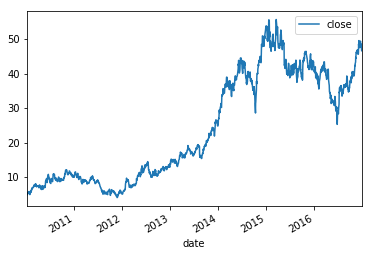

In [67]:
import matplotlib.pyplot as plt

a = df_features.loc[df_features.loc[:,'Ticker'] == 'AAL', ['date', 'close']]
a.plot(x = 'date', y = 'close')
plt.show()